In [1]:
import json, re, os
import numpy as np
import pandas as pd
import argparse
import logging

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from mva_tools.mva_training_tools import (
    train_one_signal_all_methods,
    train_one_signal_all_methods_categorized,
    load_model,
    methods_list,
)
from data_tools.load_data import (
    read_files_and_open_trees,
    get_data,
    get_categorized_data,
    filter_trees,
)
from mva_tools.mva_response_tools import (
    my_predict,
    model_response_hists,
    save_results_to_csv,
)
from mva_tools.mva_plot_tools import plot_corr_matrix
from my_logging import log_weights, log_histo_weights, log_num_events

methods_list = ["keras_shallow", "adaboost", "XGBoost"]

2023-12-15 15:05:23.824596: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ntuples_json = "cfg/ntuples.json"
vars_json = "cfg/vars_new.json"


# open trees from root files
(
    sig_trees,
    bkg_trees,
    good_vars,
    weight_name,
    sig_labels,
    bkg_labels,
) = read_files_and_open_trees(ntuples_json, vars_json, additional_vars=["C_category"])
print(f"file reading is done")
# ┌────────────────────────────────┐
# │ CHOOSE YOUR MASSES TO TRAIN ON │
# └────────────────────────────────┘
mass_list = ["mN1p0"]
my_sig_trees, my_sig_labels = filter_trees(
    sig_trees, sig_labels, mass_list=mass_list, ctau_list=["ctau1000"]
)

# ┌───────────────┐
# │ TEST FRACTION │
# └───────────────┘
test_fraction = 0.2

file reading is done


In [3]:

# ┌─────────────────────────────────────────┐
# │ TRAINING (IF ARGUMENT --train IS GIVEN) │
# └─────────────────────────────────────────┘

for sig_tree, sig_label in zip(my_sig_trees, my_sig_labels):
    # GET DATA, CATEGORIZED
    categories=[1, 2, 4, 5, 6]
    full_data = get_categorized_data(
        sig_tree,
        bkg_trees,
        good_vars,
        weight_name,
        test_fraction,
        rng_seed=42,
        equalnumevents=True,
        category_list=categories,
    )
    # TRAINING
    for category,data in zip(categories,full_data):
        print(f"Training category {category} ...")
        x_train, x_test, y_train, y_test, w_train, w_test = data

        break

INFO:root:get_categorized_data called with equalnumevents = True


data_sig['C_category']: [[2], [6], [5], [6], [6], [3], [5], [6], ..., [6], [3], [2], [6], [3], [3], [1]]
data_bkg['C_category']: [[4, 4, 4, 4], [1], [4, 4], [4], [4], [4, ..., 4], ..., [1], [1], [1], [4], [1]]
data_sig[var], type = <class 'awkward.highlevel.Array'>
ak.type(data_sig[var]): 167 * 1 * float32
data_sig[var][data_sig['C_category'] == 1], type = <class 'awkward.highlevel.Array'>
ak.type(data_sig[var][data_sig['C_category'] == 1]): 11 * float32
[16.3, 19.3, 17.1, 27.8, 18.1, 13.8, 12.5, 17.4, 18.7, 11.1, 26]
data_bkg[var], type = <class 'awkward.highlevel.Array'>
ak.type(data_bkg[var]): 489081 * var * float32
data_bkg[var][data_bkg['C_category'] == 1], type = <class 'awkward.highlevel.Array'>
ak.type(data_bkg[var][data_bkg['C_category'] == 1]): 489081 * var * float32
[[], [14.7], [], [], [], [], [], ..., [], [35], [15.7], [13.9], [], [14.5]]


INFO:root:category 1: number of signal events = 11
INFO:root:category 1: number of background events = 468828
INFO:root:category 1: before renormalization, sum of sig weights = 11.0
INFO:root:category 1: before renormalization, sum of bkg weights = 4604.501326403627
INFO:root:category 1: renormalizing signal weights by 1.0
INFO:root:category 1: renormalizing background weights by 0.002388966626401564
INFO:root:category 1: after renormalization, sum of sig weights = 11.0
INFO:root:category 1: after renormalization, sum of bkg weights = 11.000000000000004


x_sig.shape = (11, 26)
x_bkg.shape = (468828, 26)
x_sig = [[ 1.62630997e+01  2.94615841e+00  9.91747081e-01  8.28650415e-01
   8.59370708e+00  9.99998629e-01  9.95432794e-01  8.40956390e-01
   1.52787983e+00  3.41536832e+00  1.50000000e+01  3.00000000e+00
   3.92412603e-01  1.85875378e+01  1.08587561e+01  1.00000000e+01
   1.00000000e+00  0.00000000e+00  5.94129801e-01  2.95685554e+00
   2.06835938e+00  1.10000000e+01  0.00000000e+00  2.40433380e-01
   2.97932446e-01  1.00000000e+00]
 [ 1.92583523e+01  5.28186989e+00  9.99995947e-01  9.06748712e-01
   3.12236538e+01  9.99999046e-01  9.99999702e-01  9.55996156e-01
   5.91568804e+00  1.14101725e+01  1.90000000e+01  3.00000000e+00
   1.08069861e+00  4.81002121e+01  6.85080576e+00  1.30000000e+01
   2.00000000e+00  0.00000000e+00  1.62903953e+00  7.92650747e+00
   1.03417969e+00  1.10000000e+01  0.00000000e+00  8.82033259e-02
   3.34488571e-01  1.00000000e+00]
 [ 1.71107769e+01  1.63845177e+01  9.99949157e-01  8.22585583e-01
   2.07240925e

INFO:root:category 2: number of signal events = 17
INFO:root:category 2: number of background events = 15940
INFO:root:category 2: before renormalization, sum of sig weights = 17.0
INFO:root:category 2: before renormalization, sum of bkg weights = 137.91580252500057
INFO:root:category 2: renormalizing signal weights by 1.0
INFO:root:category 2: renormalizing background weights by 0.12326361220947353
INFO:root:category 2: after renormalization, sum of sig weights = 17.0
INFO:root:category 2: after renormalization, sum of bkg weights = 17.0


x_sig.shape = (17, 26)
x_bkg.shape = (15940, 26)
x_sig = [[ 2.10062542e+01  2.00469341e+01  1.00000000e+00  9.64619040e-01
   8.44319839e+01  9.99982357e-01  9.99086738e-01  4.02955145e-01
   7.60906458e+00  1.06538029e+01  2.20000000e+01  3.00000000e+00
   0.00000000e+00  7.53911667e+01  4.14968777e+00  1.60000000e+01
   3.00000000e+00  0.00000000e+00  1.28452584e-01  1.70695705e+01
   6.22656250e+00  1.50000000e+01  2.00000000e+00  2.41226181e-01
   6.02295212e-02  2.00000000e+00]
 [ 2.09549389e+01  5.14821005e+00  9.99938071e-01  7.32231200e-01
   6.17511292e+01  9.99986589e-01  4.37714279e-01  4.71923620e-01
   1.19116855e+00  8.94781113e+00  2.00000000e+01  3.00000000e+00
   1.44319115e+01  2.16827126e+01  7.76401663e+00  2.00000000e+01
   4.00000000e+00  1.49076824e+01  9.69602689e-02  4.20394020e+01
   4.27343750e+00  1.80000000e+01  4.00000000e+00  8.64957124e-02
   2.44685039e-01  2.00000000e+00]
 [ 1.41388607e+01  9.38013744e+00  9.99943316e-01  4.05549318e-01
   5.17240372e+

INFO:root:category 4: number of signal events = 15
INFO:root:category 4: number of background events = 613381
INFO:root:category 4: before renormalization, sum of sig weights = 15.0
INFO:root:category 4: before renormalization, sum of bkg weights = 7886.67069121857
INFO:root:category 4: renormalizing signal weights by 1.0
INFO:root:category 4: renormalizing background weights by 0.001901943239078282
INFO:root:category 4: after renormalization, sum of sig weights = 15.0
INFO:root:category 4: after renormalization, sum of bkg weights = 15.00000000000001


x_sig.shape = (15, 26)
x_bkg.shape = (613381, 26)
x_sig = [[ 2.68843899e+01  1.30868835e+01  9.99910414e-01  5.97680330e-01
   8.33752155e+00  1.00000000e+00 -1.95969686e-01  4.11509782e-01
   1.49869623e+01  5.69718838e+00  1.60000000e+01  3.00000000e+00
   2.12315559e+01  2.48194695e+01  8.98679447e+00  1.80000000e+01
   4.00000000e+00  1.89553452e+01  3.22806947e-02  2.91896081e+00
   1.22421875e+01  1.50000000e+01  0.00000000e+00  1.56901926e-01
   1.47210121e-01  4.00000000e+00]
 [ 4.24367523e+01  3.49811029e+00  9.99970019e-01  6.86139166e-01
   1.43553581e+01  9.99995589e-01  7.18177259e-01  2.95988947e-01
   7.17139721e+00  2.00360279e+01  2.00000000e+01  5.00000000e+00
   0.00000000e+00  4.96602783e+01  1.71327209e+01  1.90000000e+01
   2.00000000e+00  0.00000000e+00  5.38822770e-01  8.89190292e+00
   5.32031250e+00  9.00000000e+00  0.00000000e+00  4.05866578e-02
   1.53814495e-01  4.00000000e+00]
 [ 1.51934338e+01  5.14316034e+00  9.99973893e-01  2.02192515e-01
   2.68505421e

INFO:root:category 5: number of signal events = 28
INFO:root:category 5: number of background events = 22293
INFO:root:category 5: before renormalization, sum of sig weights = 28.0
INFO:root:category 5: before renormalization, sum of bkg weights = 218.9919997943402
INFO:root:category 5: renormalizing signal weights by 1.0
INFO:root:category 5: renormalizing background weights by 0.12785855203064664
INFO:root:category 5: after renormalization, sum of sig weights = 28.0
INFO:root:category 5: after renormalization, sum of bkg weights = 28.000000000000007


x_sig.shape = (28, 26)
x_bkg.shape = (22293, 26)
x_sig = [[ 2.23906765e+01  1.70947151e+01  1.00000000e+00  7.52434075e-01
   9.93875885e+01  9.99981701e-01  9.32657778e-01  2.40563825e-01
   1.15577183e+01  1.06217203e+01  1.80000000e+01  3.00000000e+00
   1.30489769e+01  2.54764576e+01  1.08720198e+01  1.80000000e+01
   3.00000000e+00  1.27986774e+01  4.13267970e-01  2.55554390e+01
   9.38476562e-01  1.70000000e+01  3.00000000e+00  1.46006957e-01
   1.68436274e-01  5.00000000e+00]
 [ 5.90054359e+01  1.21989479e+02  9.99950707e-01  5.73011041e-01
   1.10846298e+02  9.99971271e-01  8.76011133e-01  5.00859141e-01
   1.04100975e+02  3.91309700e+01  1.60000000e+01  3.00000000e+00
   5.04948959e+01  7.45409470e+01  1.86325169e+01  2.00000000e+01
   3.00000000e+00  3.98616219e+01  5.06097794e-01  5.35727882e+01
   1.27539062e+00  1.30000000e+01  3.00000000e+00  4.62494455e-02
   1.57282352e-01  5.00000000e+00]
 [ 2.10299892e+01  6.35266304e+00  9.99999583e-01  6.42187476e-01
   8.05546417e+

INFO:root:category 6: number of signal events = 44
INFO:root:category 6: number of background events = 1685
INFO:root:category 6: before renormalization, sum of sig weights = 44.0
INFO:root:category 6: before renormalization, sum of bkg weights = 13.621608801533053
INFO:root:category 6: renormalizing signal weights by 1.0
INFO:root:category 6: renormalizing background weights by 3.2301617702490466
INFO:root:category 6: after renormalization, sum of sig weights = 44.0
INFO:root:category 6: after renormalization, sum of bkg weights = 44.00000000000001


x_sig.shape = (44, 26)
x_bkg.shape = (1685, 26)
x_sig = [[1.83954258e+01 9.02024174e+00 9.99993563e-01 ... 2.15397730e-01
  1.32669330e-01 6.00000000e+00]
 [1.95967999e+01 5.38067818e+00 9.99989390e-01 ... 1.45642579e-01
  2.93343395e-01 6.00000000e+00]
 [1.67086296e+01 5.79175329e+00 9.99992847e-01 ... 2.39147678e-01
  1.77203864e-01 6.00000000e+00]
 ...
 [7.88696060e+01 8.01544342e+01 9.99996364e-01 ... 4.09935229e-02
  3.96678224e-02 6.00000000e+00]
 [4.07938805e+01 9.04323502e+01 9.99157369e-01 ... 1.24337018e-01
  5.90839423e-02 6.00000000e+00]
 [2.54953423e+01 3.94511795e+00 9.99957144e-01 ... 7.44349062e-02
  1.73544317e-01 6.00000000e+00]]
x_bkg = [[ 2.20891800e+01  1.62385619e+00 -3.15171123e-01 ...  2.30624542e-01
   1.08133428e-01  6.00000000e+00]
 [ 1.86763134e+01  4.23968925e+01 -9.99998093e-01 ...  1.03477845e-02
   4.79457736e-01  6.00000000e+00]
 [ 1.69156761e+01  4.25117340e+01 -9.99990880e-01 ...  1.64006799e-02
   6.66767776e-01  6.00000000e+00]
 ...
 [ 6.29868546e+0

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
def calculate_roc_curve(signal_responses, background_responses):
    thresholds = np.unique(np.concatenate([signal_responses, background_responses]))
    thresholds = np.sort(thresholds)[::-1]  # Sort thresholds in descending order

    tpr_list = []
    fpr_list = []

    for threshold in thresholds:
        tp = np.sum(signal_responses >= threshold)
        fp = np.sum(background_responses >= threshold)
        fn = np.sum(signal_responses < threshold)
        tn = np.sum(background_responses < threshold)

        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return tpr_list, fpr_list


In [2]:
# Assuming you have a histogram of responses in the form of two arrays: signal_responses and background_responses

# Generate some sample data for demonstration purposes
signal_responses = np.random.normal(2, 1, 1000)  # Sample signal responses
background_responses = np.random.normal(0, 1, 1000)  # Sample background responses

# Combine signal and background responses into one array
all_responses = np.concatenate([signal_responses, background_responses])

# Create labels for signal (1) and background (0)
labels = np.concatenate([np.ones(len(signal_responses)), np.zeros(len(background_responses))])




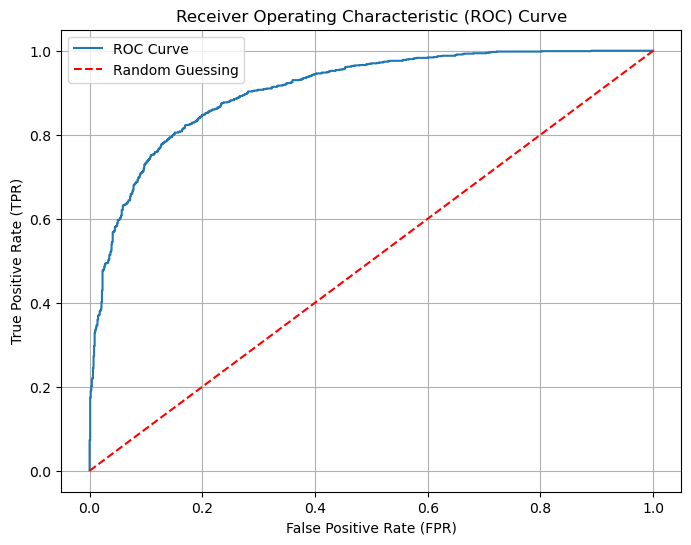

In [3]:
tpr, fpr = calculate_roc_curve(signal_responses, background_responses)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

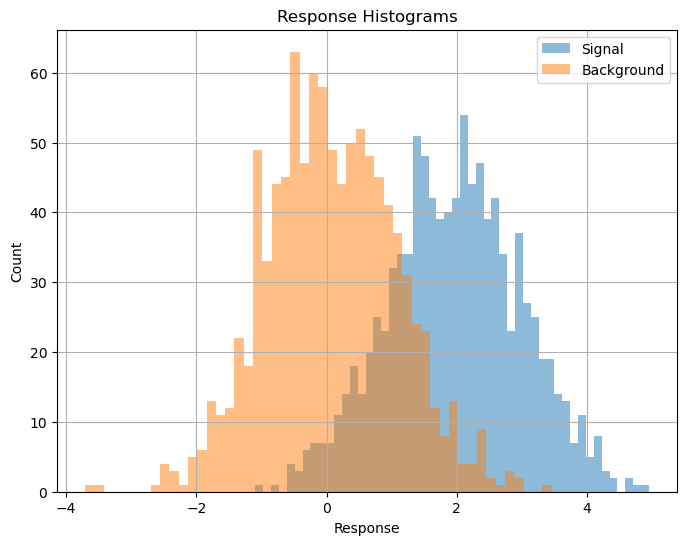

In [4]:
#plot the response histograms
plt.figure(figsize=(8, 6))
plt.hist(signal_responses, bins=50, label='Signal', alpha=0.5)
plt.hist(background_responses, bins=50, label='Background', alpha=0.5)
plt.xlabel('Response')
plt.ylabel('Count')
plt.title('Response Histograms')
plt.legend()
plt.grid()
plt.show()


In [5]:
import pandas as pd

In [6]:
#open csv file
df = pd.read_csv("/home/quibus/mva_analysis/results_categories/myMVA/mN1p0_ctau10/cat_3/XGBoost_results.csv")

In [7]:
df

,bin_center,tp,fp,tn,fn,test_sig_hist,test_bkg_hist,train_sig_hist,train_bkg_hist,sig,acc
0,-7.972299,537.0,368.316248,0.000000,0.0,0.0,0.000000,0.0,6.093427,17.847366,0.593163
1,-7.605144,537.0,368.316248,0.000000,0.0,0.0,0.000000,0.0,14.185667,17.847366,0.593163
2,-7.237990,537.0,368.316248,0.000000,0.0,0.0,0.000000,0.0,6.386801,17.847366,0.593163
3,-6.870837,537.0,368.316248,0.000000,0.0,0.0,0.048897,0.0,5.065576,17.847366,0.593163
4,-6.503683,537.0,368.267351,0.048897,0.0,0.0,0.000000,0.0,5.751328,17.847848,0.593217
5,-6.136529,537.0,368.267351,0.048897,0.0,0.0,2.548072,0.0,25.912058,17.847848,0.593217
6,-5.769375,537.0,365.719280,2.596969,0.0,0.0,6.534649,0.0,32.283621,17.873019,0.596031
7,-5.402222,537.0,359.184631,9.131617,0.0,0.0,19.104042,0.0,67.217616,17.938063,0.603250
8,-5.035068,537.0,340.080589,28.235659,0.0,0.0,17.268960,0.0,160.468298,18.132368,0.624352
9,-4.667914,537.0,322.811630,45.504619,0.0,0.0,23.522512,1.0,150.503697,18.313554,0.643427
